In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
    .appName("ReadMongoLocal") \
    .getOrCreate()

In [3]:
path = "D:/ALL_Python/EXAMPLE_DOAN/MODEL_BIGDATA/data/du_lieu.json"

df = spark.read.option("multiline", "true").json(path)

df.printSchema()

root
 |-- all_hgvs: double (nullable = true)
 |-- all_motor_vehicles: double (nullable = true)
 |-- buses_and_coaches: double (nullable = true)
 |-- cars_and_taxis: double (nullable = true)
 |-- count_date: string (nullable = true)
 |-- count_point_id: long (nullable = true)
 |-- direction_of_travel: string (nullable = true)
 |-- easting: long (nullable = true)
 |-- end_junction_road_name: string (nullable = true)
 |-- hgvs_2_rigid_axle: double (nullable = true)
 |-- hgvs_3_or_4_articulated_axle: double (nullable = true)
 |-- hgvs_3_rigid_axle: double (nullable = true)
 |-- hgvs_4_or_more_rigid_axle: double (nullable = true)
 |-- hgvs_5_articulated_axle: long (nullable = true)
 |-- hgvs_6_articulated_axle: double (nullable = true)
 |-- hour: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- lgvs: long (nullable = true)
 |-- link_length_km: double (nullable = true)
 |-- link_length_miles: double (nullable = true)
 |-- local_authority_id: long (nullable = true)
 |-- loc

In [4]:
from pyspark.sql.functions import avg, col

# Lưu lượng trung bình theo giờ (tổng hợp tất cả phương tiện)
df_hourly = df.groupBy("hour") \
    .agg(avg("all_motor_vehicles").alias("avg_traffic_volume")) \
    .orderBy("hour")

df_hourly.show(24, truncate=False)


+----+------------------+
|hour|avg_traffic_volume|
+----+------------------+
|0   |39.0              |
|1   |138.25            |
|3   |28.0              |
|4   |570.0             |
|5   |5.0               |
|7   |577.1854148336294 |
|8   |643.9531328681389 |
|9   |507.78115238292867|
|10  |454.2282037589887 |
|11  |459.1823604766661 |
|12  |474.545321738553  |
|13  |488.58619468438906|
|14  |507.68468131965426|
|15  |561.9694046100595 |
|16  |638.4073215338091 |
|17  |666.9958193494122 |
|18  |535.4793953915623 |
+----+------------------+



In [5]:
from pyspark.sql.functions import (
    col, count, avg, sum as _sum, year, dayofweek, to_date, date_format
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 1. CHUYỂN KIỂU DỮ LIỆU
# -----------------------------
df = df.withColumn("count_date", to_date(col("count_date")))
numeric_cols = [
    "pedal_cycles", "two_wheeled_motor_vehicles", "cars_and_taxis",
    "buses_and_coaches", "lgvs", "all_hgvs", "all_motor_vehicles"
]

# Ép kiểu sang float cho an toàn
for c in numeric_cols:
    df = df.withColumn(c, col(c).cast("double"))

In [7]:
print(f"Tổng số bản ghi: {df.count():,}")

Tổng số bản ghi: 4,337,136


In [ ]:
# 2. THỐNG KÊ CƠ BẢN
# -----------------------------
print("\n--- THỐNG KÊ CƠ BẢN ---")
df.describe(numeric_cols).show(truncate=False)

print("\nPhân bổ theo loại đường:")
df.groupBy("road_type").count().orderBy(col("count").desc()).show()

print("\nPhân bổ theo hướng di chuyển:")
df.groupBy("direction_of_travel").count().orderBy(col("count").desc()).show()


--- THỐNG KÊ CƠ BẢN ---
+-------+------------------+--------------------------+------------------+-----------------+------------------+-----------------+------------------+
|summary|pedal_cycles      |two_wheeled_motor_vehicles|cars_and_taxis    |buses_and_coaches|lgvs              |all_hgvs         |all_motor_vehicles|
+-------+------------------+--------------------------+------------------+-----------------+------------------+-----------------+------------------+
|count  |4337136           |4337136                   |4337135           |4337131          |4337136           |4337127          |4337121           |
|mean   |2.8158478313799704|4.990590334266668         |422.50701050347755|5.644446294105482|72.64290398087586 |37.21354228271388|542.9991040139299 |
|stddev |13.764591623032338|14.171025450344876        |629.9613378063625 |11.24551618341822|121.45659267342812|93.5051420673799 |823.9446868989776 |
|min    |0.0               |0.0                       |0.0               |0.0    

C:\Users\DELL\AppData\Local\Temp\ipykernel_18924\3989134119.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=road_type_pd, x="road_type", y="count", palette="Blues_d")


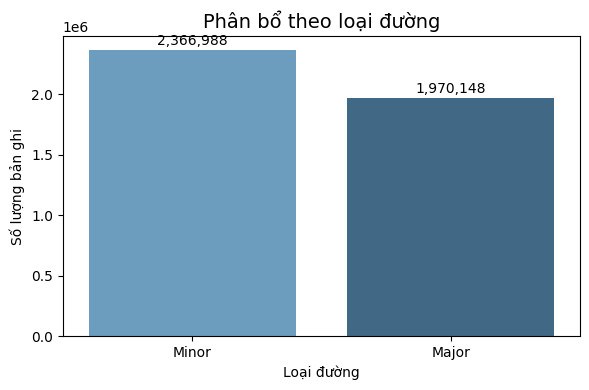

In [ ]:
from pyspark.sql import functions as F
# 3. Phân bổ theo loại đường
# ==========================
road_type_df = df.groupBy("road_type").count().orderBy(F.col("count").desc())
road_type_pd = road_type_df.toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=road_type_pd, x="road_type", y="count", palette="Blues_d")

# Hiển thị số lượng trên từng cột
for i, v in enumerate(road_type_pd["count"]):
    plt.text(i, v + 20000, f"{v:,}", ha="center", va="bottom", fontsize=10)

plt.title("Phân bổ theo loại đường", fontsize=14)
plt.xlabel("Loại đường")
plt.ylabel("Số lượng bản ghi")
plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_18924\2569591891.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=direction_pd, x="direction_of_travel", y="count", palette="viridis")


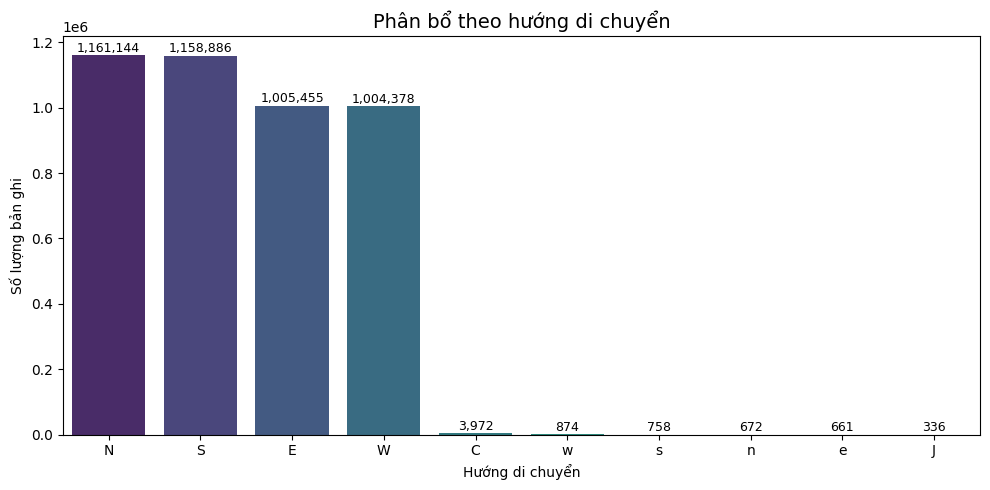

In [17]:
# =================================
# 4. Phân bổ theo hướng di chuyển
# =================================
direction_df = df.groupBy("direction_of_travel").count().orderBy(F.col("count").desc())
direction_pd = direction_df.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=direction_pd, x="direction_of_travel", y="count", palette="viridis")

# Hiển thị số lượng trên từng cột
for i, v in enumerate(direction_pd["count"]):
    plt.text(i, v + 1000, f"{v:,}", ha="center", va="bottom", fontsize=9)

plt.title("Phân bổ theo hướng di chuyển", fontsize=14)
plt.xlabel("Hướng di chuyển")
plt.ylabel("Số lượng bản ghi")
plt.tight_layout()
plt.show()


--- 5. LƯU LƯỢNG TRUNG BÌNH THEO GIỜ ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_18924\3698015407.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="hour", y="avg_traffic", data=hourly_pd, palette="viridis")


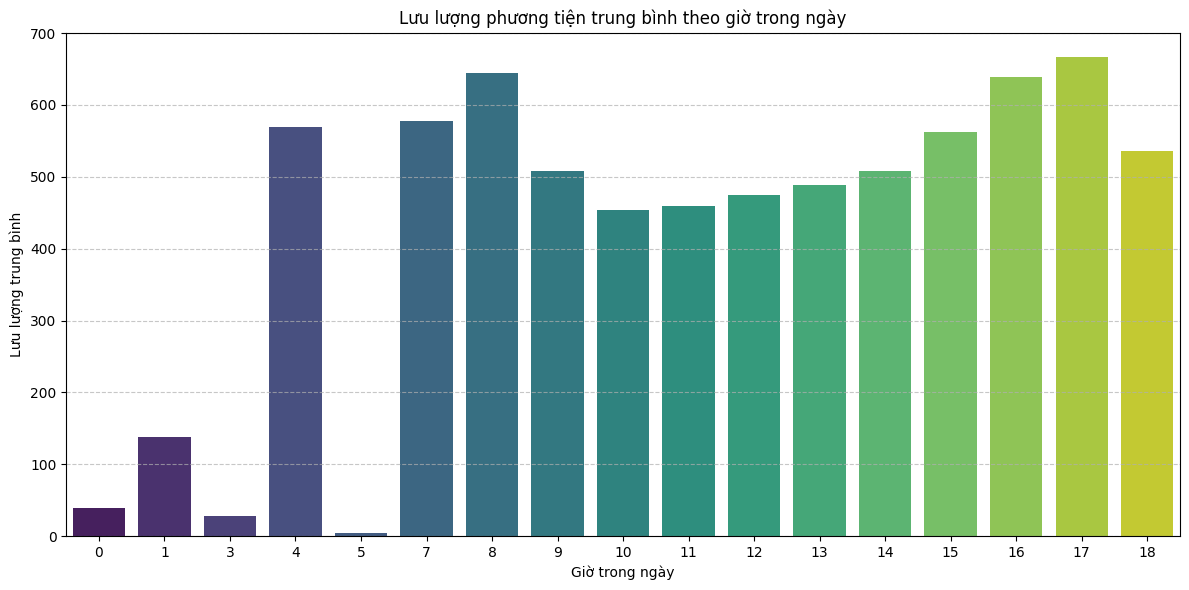

In [9]:
# 5. PHÂN TÍCH THEO GIỜ TRONG NGÀY
# -----------------------------
print("\n--- 5. LƯU LƯỢNG TRUNG BÌNH THEO GIỜ ---")
hourly = df.groupBy("hour").agg(avg("all_motor_vehicles").alias("avg_traffic")).orderBy("hour")

# Lưu lại và vẽ biểu đồ
hourly_pd = hourly.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="hour", y="avg_traffic", data=hourly_pd, palette="viridis")
plt.title("Lưu lượng phương tiện trung bình theo giờ trong ngày")
plt.xlabel("Giờ trong ngày")
plt.ylabel("Lưu lượng trung bình")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("hourly_traffic.png")


--- 6. LƯU LƯỢNG TRUNG BÌNH THEO NGÀY TRONG TUẦN ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_18924\863761592.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="day_of_week", y="avg_traffic", data=daily_pd, palette="plasma")


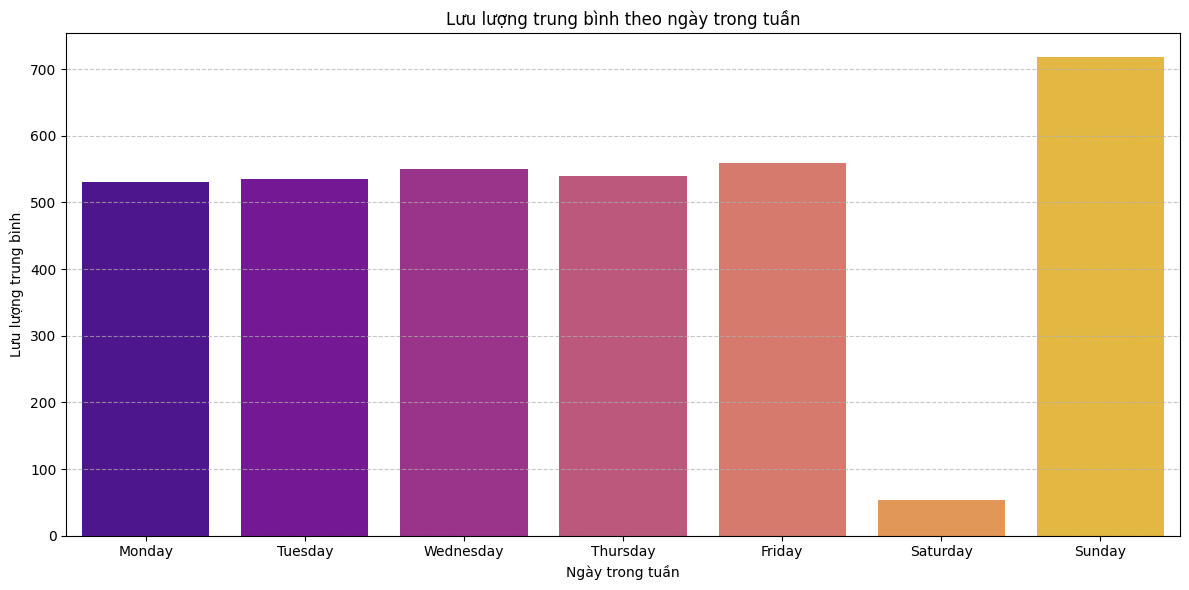

In [10]:
# 6. PHÂN TÍCH THEO NGÀY TRONG TUẦN
# -----------------------------
print("\n--- 6. LƯU LƯỢNG TRUNG BÌNH THEO NGÀY TRONG TUẦN ---")

# dayofweek: 1 = Chủ nhật, 2 = Thứ 2, ..., 7 = Thứ 7
df = df.withColumn("day_of_week", date_format(col("count_date"), "EEEE"))

daily = df.groupBy("day_of_week").agg(avg("all_motor_vehicles").alias("avg_traffic"))

# Đảm bảo thứ tự đúng
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_pd = daily.toPandas()
daily_pd["day_of_week"] = pd.Categorical(daily_pd["day_of_week"], categories=order_days, ordered=True)
daily_pd = daily_pd.sort_values("day_of_week")

plt.figure(figsize=(12, 6))
sns.barplot(x="day_of_week", y="avg_traffic", data=daily_pd, palette="plasma")
plt.title("Lưu lượng trung bình theo ngày trong tuần")
plt.xlabel("Ngày trong tuần")
plt.ylabel("Lưu lượng trung bình")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("daily_traffic.png")

In [ ]:
# Tổng phương tiện theo vùng (region_name)
from pyspark.sql.functions import col, avg, sum, count, hour, desc
region_stats = df.groupBy("region_name").agg(
    sum("all_motor_vehicles").alias("total_vehicles"),
    avg("all_motor_vehicles").alias("avg_vehicles")
)
region_stats.orderBy(desc("total_vehicles")).show()


+--------------------+--------------+-----------------+
|         region_name|total_vehicles|     avg_vehicles|
+--------------------+--------------+-----------------+
|          South East|  4.28111212E8|612.5824546441863|
|          North West|  3.20896625E8|637.0674834080788|
|              London|  2.61118903E8|727.4905288203025|
|     East of England|  2.47339019E8|517.7120840432524|
|       West Midlands|  2.26720486E8|536.6521000208298|
|Yorkshire and The...|  2.01994438E8| 543.767600249817|
|          South West|  1.81407778E8|424.5244266591781|
|       East Midlands|  1.74954944E8|512.2846576617992|
|               Wales|  1.07639758E8| 410.207802502258|
|          North East|  1.05733763E8|518.7655800763426|
|            Scotland|   9.9135891E7|368.7268132113368|
+--------------------+--------------+-----------------+



In [11]:
# 7. PHÂN TÍCH THEO VỊ TRÍ
# -----------------------------
print("\n--- 7. PHÂN TÍCH THEO VỊ TRÍ ---")

# Top 10 con đường đông đúc nhất
top_roads = df.groupBy("road_name").agg(_sum("all_motor_vehicles").alias("total_traffic")) \
    .orderBy(col("total_traffic").desc()).limit(10)
print("\nTop 10 con đường đông đúc nhất:")
top_roads.show(truncate=False)

# Top 10 khu vực có nhiều điểm đếm nhất
print("\nTop 10 khu vực có nhiều điểm đếm nhất:")
df.groupBy("local_authority_name").count().orderBy(col("count").desc()).limit(10).show(truncate=False)


--- 7. PHÂN TÍCH THEO VỊ TRÍ ---

Top 10 con đường đông đúc nhất:
+---------+-------------+
|road_name|total_traffic|
+---------+-------------+
|U        |1.06014334E8 |
|C        |7.8238458E7  |
|M1       |6.572483E7   |
|M25      |5.7709744E7  |
|A1       |5.752429E7   |
|M6       |5.5604092E7  |
|M4       |5.1581189E7  |
|M60      |3.7051634E7  |
|M5       |3.676835E7   |
|A38      |3.5682392E7  |
+---------+-------------+


Top 10 khu vực có nhiều điểm đếm nhất:
+--------------------+------+
|local_authority_name|count |
+--------------------+------+
|Hampshire           |120624|
|Essex               |116376|
|Kent                |111600|
|Surrey              |103080|
|Lancashire          |91392 |
|Hertfordshire       |91296 |
|Norfolk             |81192 |
|West Sussex         |70308 |
|Staffordshire       |66528 |
|Devon               |66024 |
+--------------------+------+



C:\Users\DELL\AppData\Local\Temp\ipykernel_18924\4035546623.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


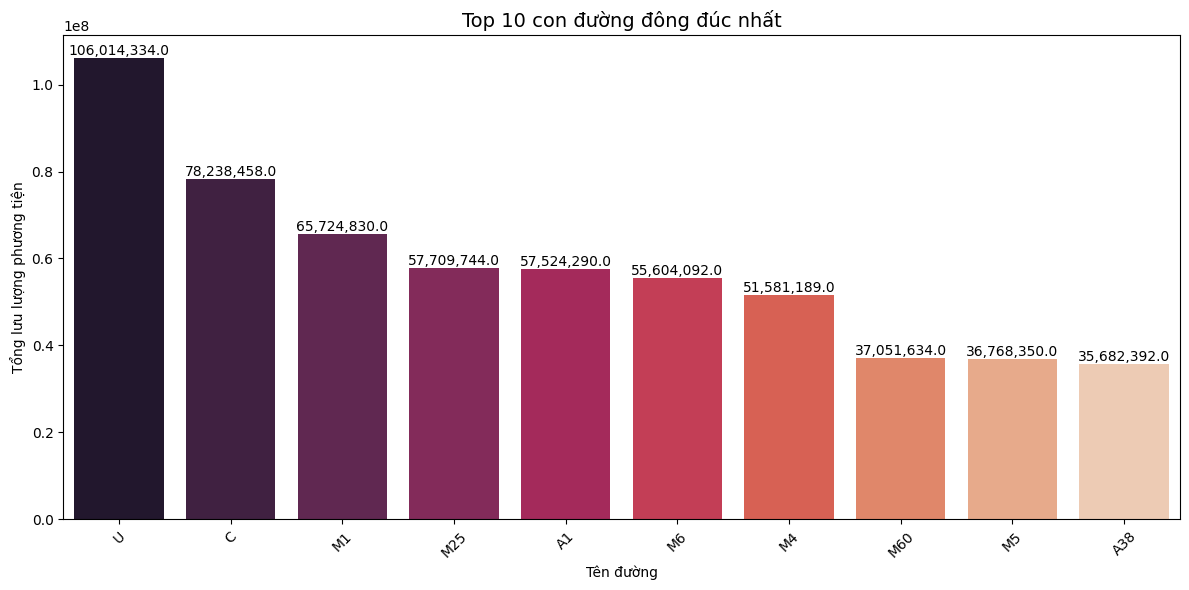

C:\Users\DELL\AppData\Local\Temp\ipykernel_18924\4035546623.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


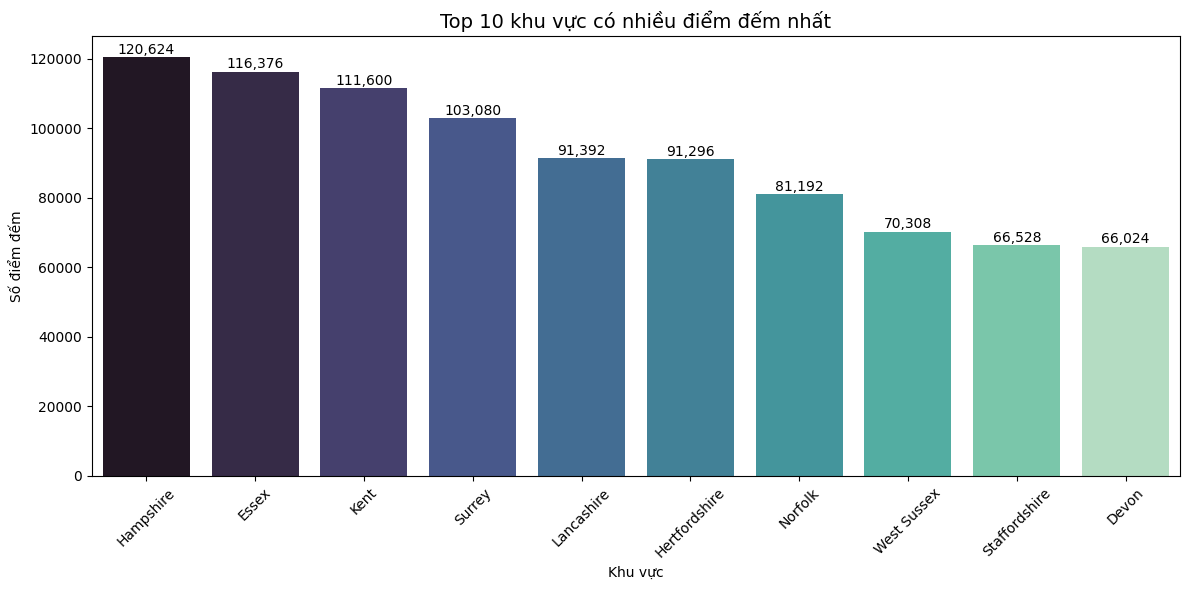

In [18]:
# --- Top 10 con đường đông đúc nhất ---
top_roads_pd = top_roads.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_roads_pd,
    x="road_name",
    y="total_traffic",
    palette="rocket"
)

# Hiển thị số lượng trên từng cột
for i, v in enumerate(top_roads_pd["total_traffic"]):
    plt.text(i, v + 500, f"{v:,}", ha="center", va="bottom", fontsize=10)

plt.title("Top 10 con đường đông đúc nhất", fontsize=14)
plt.xlabel("Tên đường")
plt.ylabel("Tổng lưu lượng phương tiện")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Top 10 khu vực có nhiều điểm đếm nhất ---
top_authorities = df.groupBy("local_authority_name").count().orderBy(col("count").desc()).limit(10)
top_authorities_pd = top_authorities.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_authorities_pd,
    x="local_authority_name",
    y="count",
    palette="mako"
)

# Hiển thị số lượng trên từng cột
for i, v in enumerate(top_authorities_pd["count"]):
    plt.text(i, v + 50, f"{v:,}", ha="center", va="bottom", fontsize=10)

plt.title("Top 10 khu vực có nhiều điểm đếm nhất", fontsize=14)
plt.xlabel("Khu vực")
plt.ylabel("Số điểm đếm")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- 8. TỔNG HỢP LƯU LƯỢNG XE THEO NĂM ---
    year  total_cars_and_taxis  total_lgvs  total_buses_and_coaches  \
0   2000           100677849.0  15874559.0                1428400.0   
1   2001           107985870.0  17121975.0                1584419.0   
2   2002           104179345.0  16200579.0                1520213.0   
3   2003           103287887.0  16096236.0                1565517.0   
4   2004            97285597.0  15572605.0                1496508.0   
5   2005            92766517.0  15086367.0                1362999.0   
6   2006            97602126.0  16449287.0                1508627.0   
7   2007            96845918.0  16812618.0                1384637.0   
8   2008           105637815.0  18008139.0                1571692.0   
9   2009           117599098.0  19269132.0                1691613.0   
10  2010           102291226.0  17185988.0                1296666.0   
11  2011            84719961.0  14741947.0                1033484.0   
12  2012            89234522.0  15

C:\Users\DELL\AppData\Local\Temp\ipykernel_18924\2872080402.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="year", y="total_all_motor_vehicles", data=yearly_pd, palette="crest", label="Tổng phương tiện có động cơ")


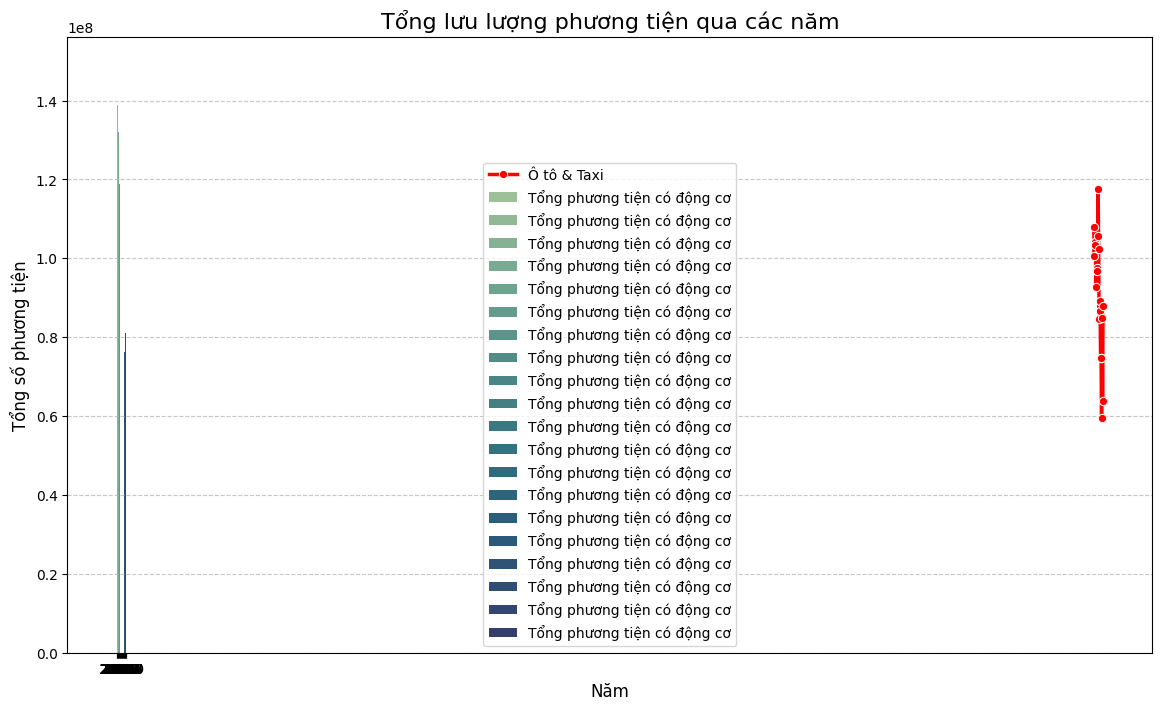

In [19]:
# 8. THỐNG KÊ LƯU LƯỢNG XE THEO NĂM
# -----------------------------
print("\n--- 8. TỔNG HỢP LƯU LƯỢNG XE THEO NĂM ---")

yearly = df.groupBy("year").agg(
    _sum("cars_and_taxis").alias("total_cars_and_taxis"),
    _sum("lgvs").alias("total_lgvs"),
    _sum("buses_and_coaches").alias("total_buses_and_coaches"),
    _sum("two_wheeled_motor_vehicles").alias("total_two_wheeled_motor_vehicles"),
    _sum("all_motor_vehicles").alias("total_all_motor_vehicles"),
    count("*").alias("record_count")
).orderBy("year")

yearly_pd = yearly.toPandas()
print(yearly_pd)

# Vẽ biểu đồ tổng lưu lượng theo năm
plt.figure(figsize=(14, 8))
sns.barplot(x="year", y="total_all_motor_vehicles", data=yearly_pd, palette="crest", label="Tổng phương tiện có động cơ")
sns.lineplot(x="year", y="total_cars_and_taxis", data=yearly_pd, marker="o", color="red", linewidth=2.5, label="Ô tô & Taxi")
plt.title("Tổng lưu lượng phương tiện qua các năm", fontsize=16)
plt.xlabel("Năm", fontsize=12)
plt.ylabel("Tổng số phương tiện", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("yearly_traffic_summary.png")

In [ ]:
spark.stop()